In [ ]:
%matplotlib inline
%load_ext tensorboard

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms.functional as TF
from torchvision import datasets, transforms

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import random

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = [12, 8]

from google.colab import drive
drive.mount('/content/drive')

## A simple average filter (`cv2.blur()`) with `PyTorch`
First we will implement an average filter using `PyTorch` with a `Conv2D` layer. As a reminder, a convolutional layer takes as inputs:
* the number of channel at the input
* the number of channel at the output
* the kernel size
* the stride
* the padding
* the dilation




In [ ]:
img = cv2.imread('drive/My Drive/Colab Notebooks/computer_vision/images/boat.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap=cm.gray)
plt.show()

We need to define the operation performed by our average filter inside our `class`. All network modules must be a subclass of the base class: `nn.Module`.

In [ ]:
class Unif_Blur(nn.Module):
    def __init__(self, kernel):
        super(Unif_Blur, self).__init__()

        assert(kernel % 2 == 1)

        padding = (kernel - 1)//2 
        self.filter = nn.Conv2d(1, 1, kernel_size=kernel, padding=padding) # out_dim = [(in_dim + 2*padding - dilation*(kernel-1) - 1)/stride] + 1
        
        self.filter.weight = nn.Parameter((1/kernel**2)*torch.ones_like(self.filter.weight))
        
    def forward(self, x):
        return self.filter(x)

In [ ]:
blur = Unif_Blur(5)

img_tensor = torch.from_numpy(img)
img_tensor = torch.unsqueeze(img_tensor, 0) # add channel dim
img_tensor = torch.unsqueeze(img_tensor, 0) # add bs dim

blured_image = blur(img_tensor.float())
blured_image = np.reshape(blured_image.data.numpy(), (512, 512))

plt.imshow(blured_image, cmap=cm.gray)
plt.show()

## Classification
Classification is the most applied task in computer vision and is performed with convolutional neural networks (CNN). The basic idea for classification is to first extract features of an input image an then try to classify those features in order to predict the class of that image.  
In this tutorial, we will apply image classification on the MNIST dataset (handwritten numbers).  
The first task is to implement the `ConvNet` represented in the figure below.
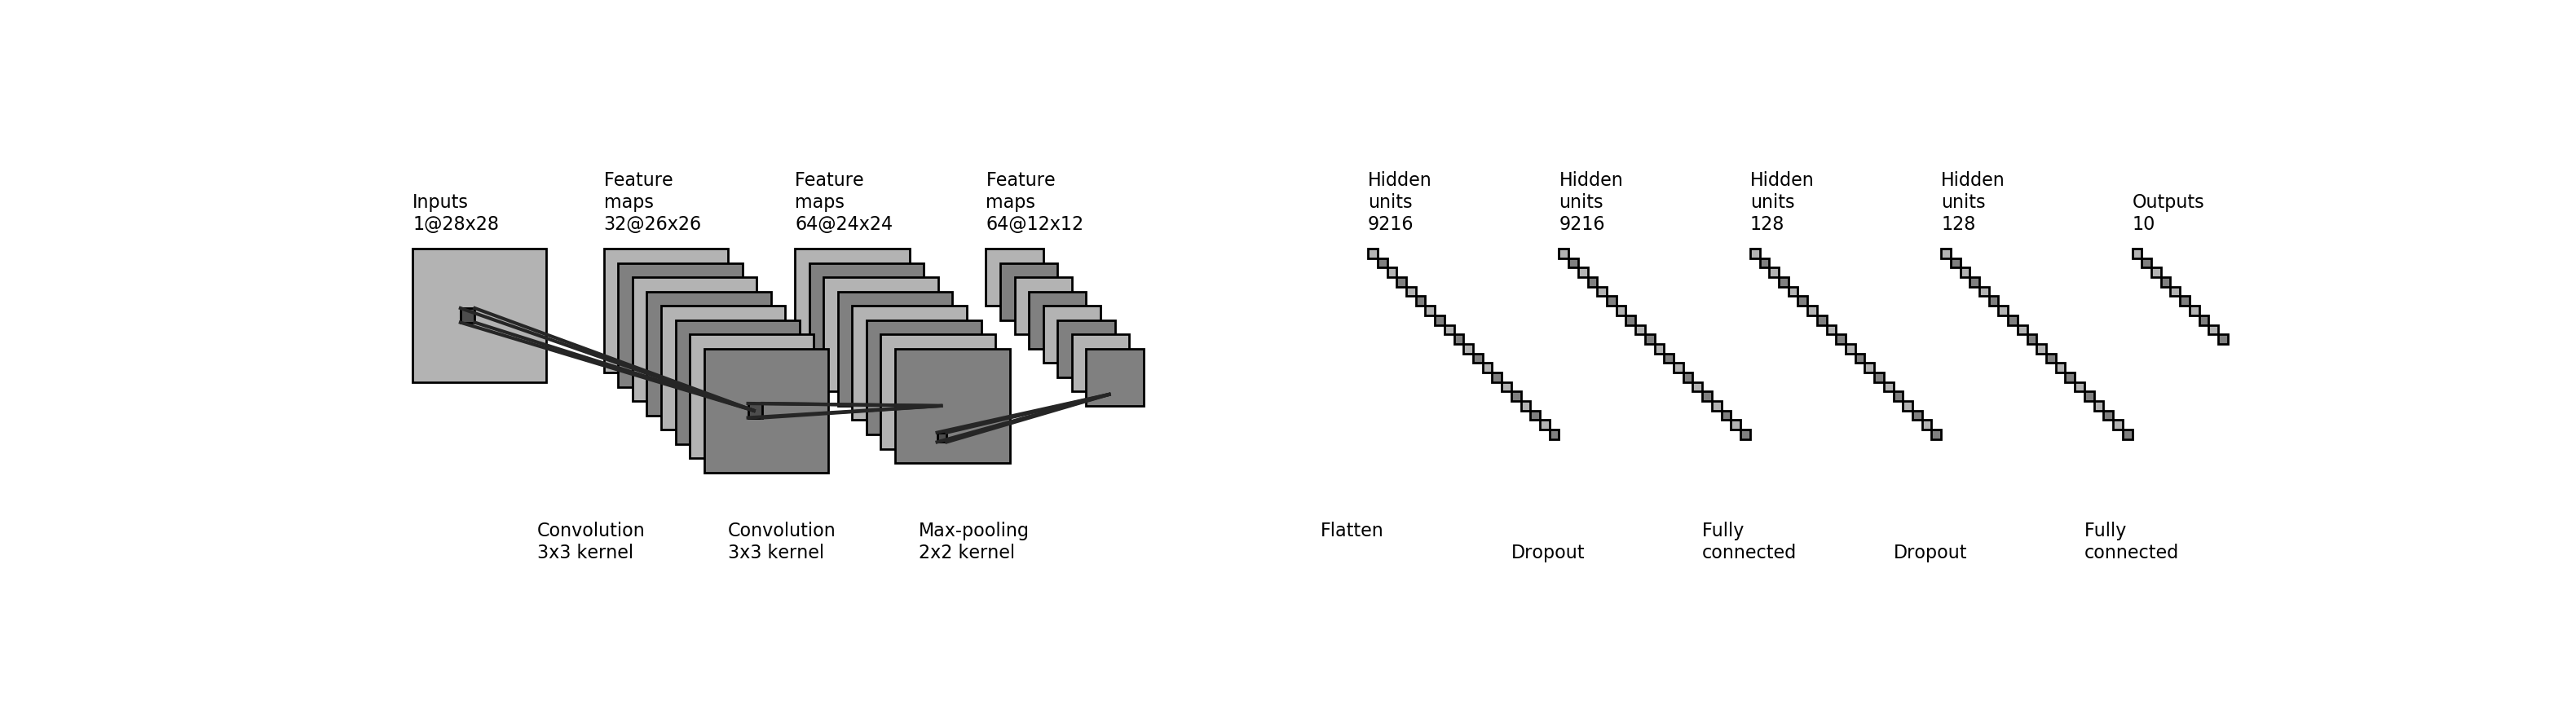

### Definition of the computation graph

In [ ]:
class ClassNet(nn.Module):
    def __init__(self, output_dim):
        super(ClassNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(9216, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, output_dim),
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Definition of the data loader
We can retrieve the dataset from `PyTorch` and then define our `DataLoader`.

In [ ]:
train_mnist = datasets.MNIST('drive/My Drive/Colab Notebooks/computer_vision/data', train=True, download=True,
                             transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                             ]))
test_mnist = datasets.MNIST('drive/My Drive/Colab Notebooks/computer_vision/data', train=False, download=True,
                            transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                            ]))

train_loader = DataLoader(train_mnist, batch_size=32, num_workers=4, shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=256, num_workers=4, shuffle=False)

### Definition of the setup
Here we have to define the `ConvNet` model that we will use. We also need to define our loss function aswel as an optimizer.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ClassNet(10).to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
def compute_accuracy(y_pred, y_true):
    pred = y_pred.argmax(1, keepdim=True)
    correct = pred.eq(y_true.view_as(pred)).sum()
    accuracy = correct.float()/pred.shape[0]
    return accuracy

### Definition of a training loop
We can define a training loop where we pass sequentially the training data and we process the forward and backward passes.

In [ ]:
def train_one_epoch(model, optimizer, train_loader, device, criterion):
    model.train()
    
    train_loss = 0
    train_acc = 0
    
    for iter_num, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        acc = compute_accuracy(outputs, targets.to(device))
        train_acc += acc.item()
        
    print('train loss: {}, train accuracy:{}'.format(train_loss/len(train_loader), 100*train_acc/len(train_loader)))
    
def test(model, test_loader, device, critetion):
    model.eval()
    
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for iter_num, (inputs, targets) in enumerate(test_loader):
            outputs = model(inputs.to(device))

            loss = criterion(outputs, targets.to(device))        
            test_loss += loss.item()

            acc = compute_accuracy(outputs, targets.to(device))
            test_acc += acc.item()
        
    print('test loss: {}, test accuracy:{}'.format(test_loss/len(test_loader), 100*test_acc/len(test_loader)))
    
def train(num_epoch=10):
    for epoch in range(num_epoch):
        print('epoch: {}/{}'.format(epoch+1, num_epoch))
        train_one_epoch(model, optimizer, train_loader, device, criterion)
        test(model, test_loader, device, criterion)

In [ ]:
train(num_epoch=5)

## Object detection
For object detection, the basic idea is the same as for the classification task. First we extract the features, then we perform a classification (to predict the classes) and a regression (to predict the bouding boxes).  
For this tutorial we will use the `RetinaNet` architecture. It is composed of a backbone network (extract the features), a Feature Pyramid Network (merge the features of different pyramid layer) and 2 subnetworks (classification/regression). 
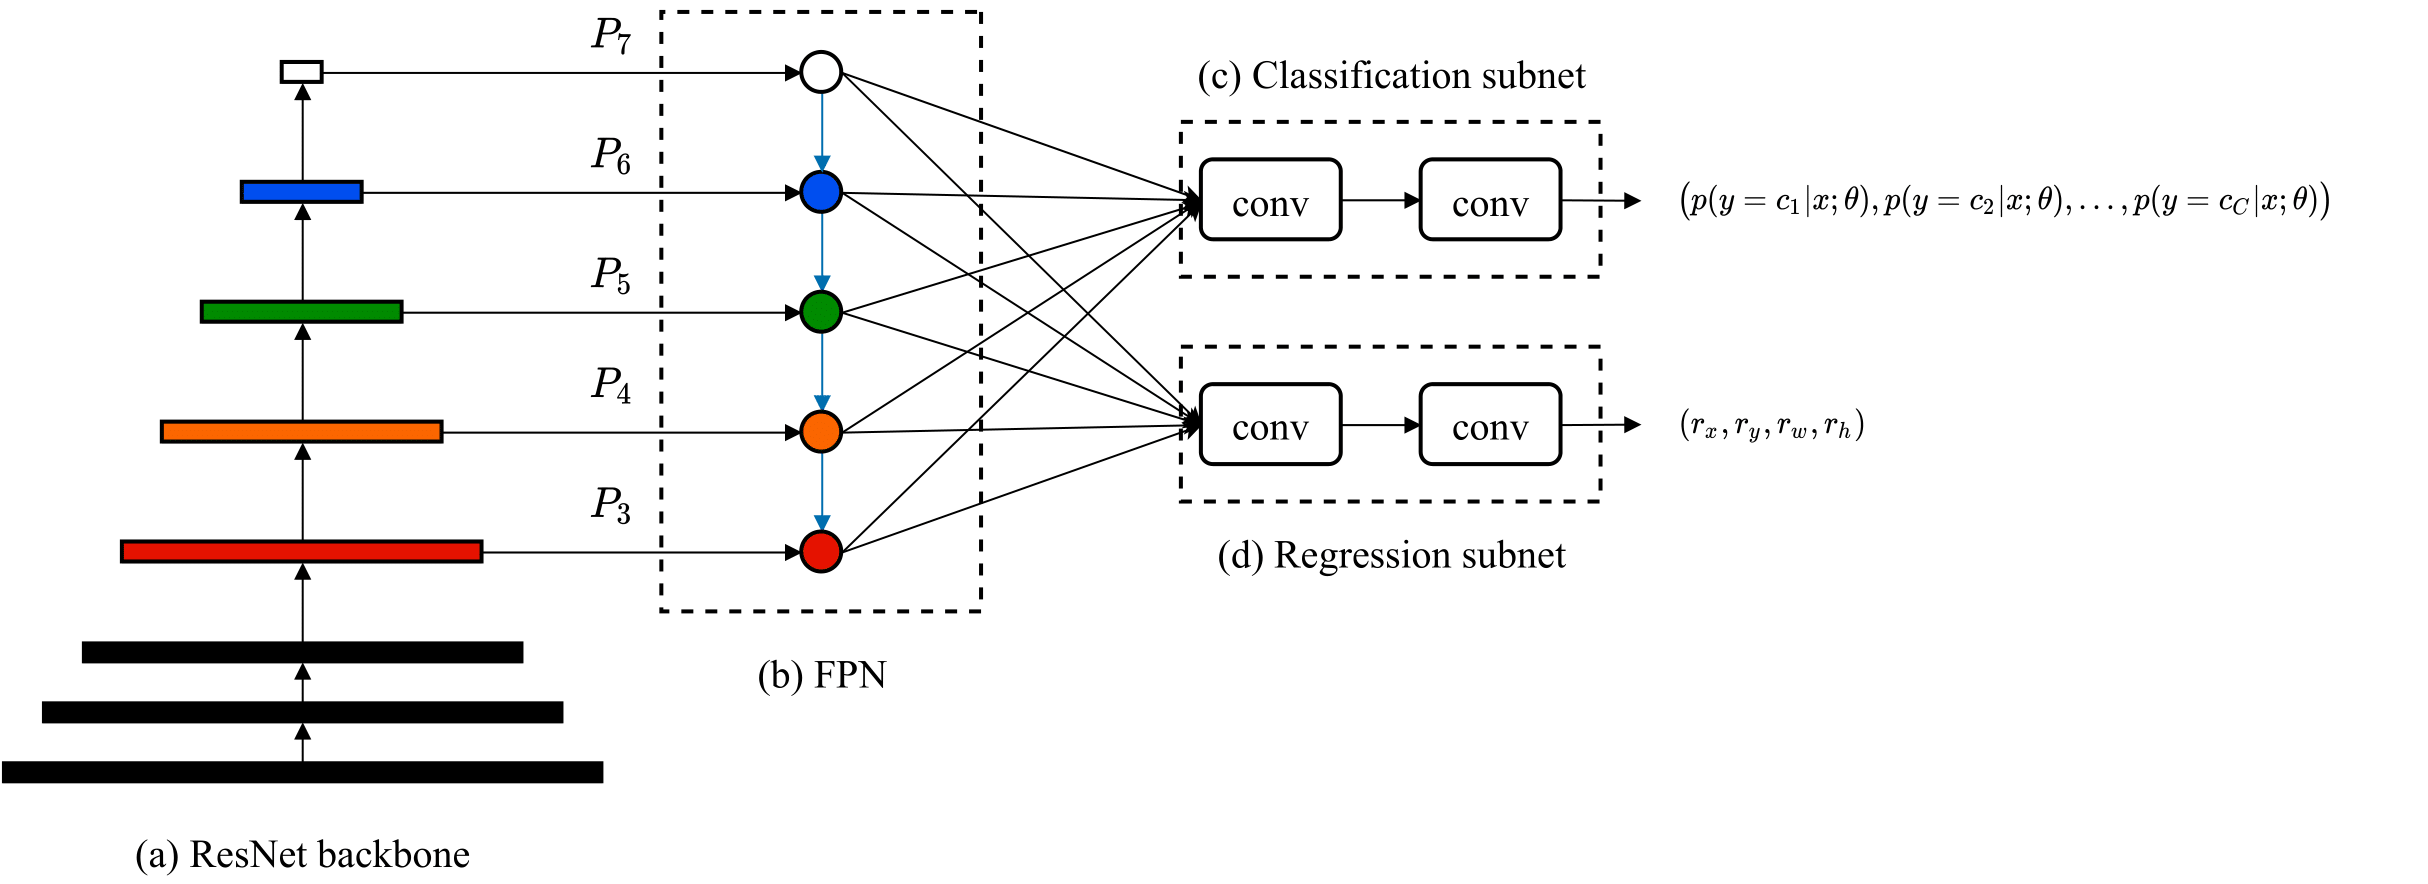


### Anchors
One fundamental concept with this architecture is the anchor. Anchors are pre-defined boxes with multiple scales and aspect ratios which are used as reference boxes. Anchors are assigned to a ground truth object’s box using an intersection-over-union (IoU) threshold of 0.5, and to background if their IoU is in the interval [0, 0.4).  
Most of the time, we define ~100k anchors per images.  
In the following figure, we can see some anchors with different scales and aspect ratios.  
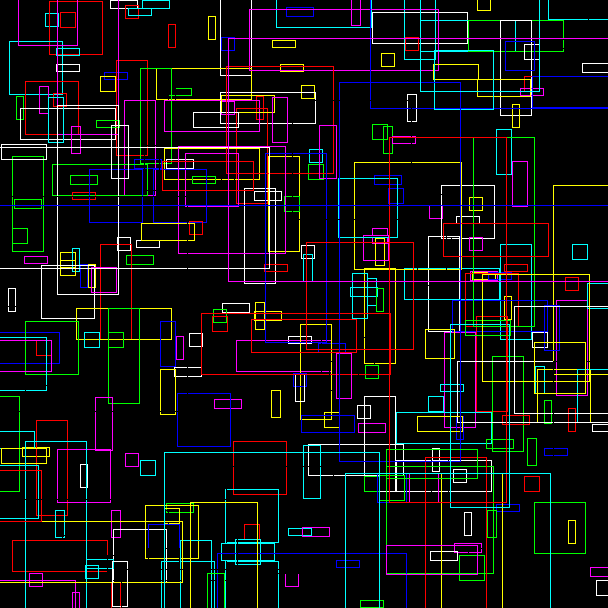  
Finally the following figure shows how anchors (green) are assigned to ground truths (red).  
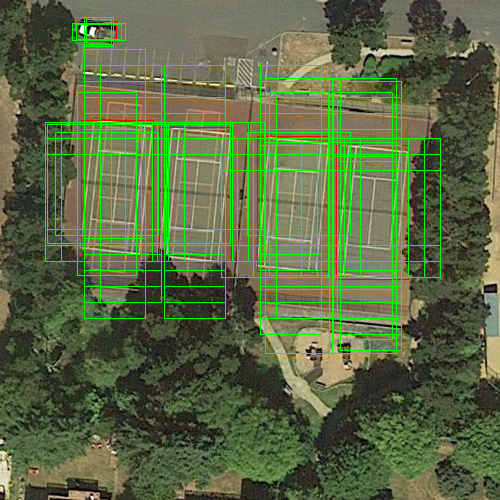

In [ ]:
 import sys
sys.path.append('drive/My Drive/Colab Notebooks/computer_vision/')

In [ ]:
from retinanet import model as retinanet

### Definition of a `Dataset`
For this example, we will use a custom dataset (cards) thus we will define a `Dataset class` to retrieve the data.  
We will define a `Dataset`, a `Resizer`, a `Augmenter`, a `Normalizer` and an `UnNormalizer`.  
Finally, we will define a `collater` given that our data have not the same number of object per image.

In [ ]:
class csvdataloader(Dataset):
    
    def __init__(self, root, file, transform=None):
        self.root = root
        self.file = file
        self.transform = transform

        self.image_data, self.classes = self.read_annotations()
        
        self.classes = list(set(self.classes))
        
        self.image_names = list(self.image_data.keys())
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        annotation = self.load_annotations(idx)
        
        sample = {'image': image, 'annotation': annotation, 'idx': idx}

        if self.transform:
            sample = self.transform(sample)
        
        return sample
        
    def load_annotations(self, index):
        annotation_list = self.image_data[self.image_names[index]]
        
        annotations = torch.zeros((0, 5))
        
        if len(annotation_list) == 0:
            return annotations
        
        for _, annot in enumerate(annotation_list):
            x1 = int(annot['x1'])
            y1 = int(annot['y1'])
            x2 = int(annot['x2'])
            y2 = int(annot['y2'])
            
            annotation = torch.zeros((1, 5))
            
            annotation[0, 0] = x1
            annotation[0, 1] = y1
            annotation[0, 2] = x2
            annotation[0, 3] = y2
            
            annotation[0, 4] = int(self.classes.index(annot['label']))
            
            annotations = torch.cat((annotations, annotation), axis=0)
            
        return annotations
        
    def load_image(self, index):
        image = Image.open(self.image_names[index]).convert('RGB')
        
        return image
    
    def read_annotations(self):
        with open(self.file, newline='') as csvfile:
            f = pd.read_csv(csvfile, header=0)
            
            annotations = {}
            classes = []
            for index, row in f.iterrows():
                image_name = row[0]
                x1 = row[4]
                y1 = row[5]
                x2 = row[6]
                y2 = row[7]
                label = row[3]
                
                classes.append(label)
                
                path = os.path.join(self.root, image_name)
                
                if path not in annotations:
                    annotations[path] = []
                    
                annotations[path].append({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'label': label})
        
        return annotations, classes

class Resizer(object):
    def __init__(self, dims=(224, 224)):
        self.dims = dims

    def __call__(self, sample):
        image, annots = sample['image'], sample['annotation']

        w, h = image.size
        
        image = TF.resize(image, self.dims, Image.LANCZOS)
        image = TF.to_tensor(image)

        scale = torch.tensor([self.dims[0]/w, self.dims[1]/h])

        annots[:, 0] *= scale[0]
        annots[:, 1] *= scale[1]
        annots[:, 2] *= scale[0]
        annots[:, 3] *= scale[1]

        sample['image'] = image
        sample['annotation'] = annots
        sample['scale'] = scale

        return sample

class Augmenter(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        image, annots = sample['image'], sample['annotation']

        if random.random() < self.prob:
            image = TF.to_pil_image(image)
            image = TF.hflip(image)

            w, h = image.size

            image = TF.to_tensor(image)

            x1 = annots[:, 0].clone()
            x2 = annots[:, 2].clone()
            x_tmp = x1.clone()

            annots[:, 0] = w - x2
            annots[:, 2] = w - x_tmp

            sample['image'] = image
            sample['annotation'] = annots

        return sample

class Normalizer(object):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image = sample['image']
        image = TF.normalize(image, self.mean, self.std)

        sample['image'] = image

        return sample

class UnNormalizer(object):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)

        return tensor

def collater(data):
    images = [s['image'] for s in data]
    annots = [s['annotation'] for s in data]
    scales = [s['scale'] for s in data]
    idxs = [s['idx'] for s in data]

    max_num_annots = max(annot.shape[0] for annot in annots)

    if max_num_annots > 0:
        annot_ = torch.ones((len(annots), max_num_annots, 5)) * -1

        if max_num_annots > 0:
            for idx, annot in enumerate(annots):
                if annot.shape[0] > 0:
                    annot_[idx, :annot.shape[0], :] = annot
    else:
        annot_ = torch.ones((len(annots), 1, 5)) * -1

    images = torch.stack(images)

    return {'image': images, 'annotation': annot_, 'scale': scales, 'idx': idxs}

In [ ]:
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

def draw_bb(data, classes):
    image_tensor = data['image']
    annotations = data['annotation']
        
    image = np.array(255*UnNormalizer()(image_tensor))
    image = np.clip(image, 0, 255)
    image = np.transpose(image, (1, 2, 0))

    image = image.astype(np.uint8).copy()
    
    for i in range(annotations.shape[0]):
        x1 = int(annotations[i, 0])
        y1 = int(annotations[i, 1])
        x2 = int(annotations[i, 2])
        y2 = int(annotations[i, 3])
        
        image = cv2.rectangle(image, (x1, y1),(x2, y2), (0, 255, 0), 2)
        draw_caption(image, (x1, y1, x2, y2), classes[int(annotations[i, 4])])

    plt.imshow(image)
    plt.show()

### Definition of the training setup

In [ ]:
train_dataset = csvdataloader('drive/My Drive/Colab Notebooks/computer_vision/data/cards/train',
                              'drive/My Drive/Colab Notebooks/computer_vision/data/cards/train_labels.csv',
                              transform=transforms.Compose([Resizer(), Augmenter(), Normalizer()]))

test_dataset = csvdataloader('drive/My Drive/Colab Notebooks/computer_vision/data/cards/test',
                             'drive/My Drive/Colab Notebooks/computer_vision/data/cards/test_labels.csv',
                             transform=transforms.Compose([Resizer(), Normalizer()]))

train_loader = DataLoader(train_dataset, num_workers=4, collate_fn=collater, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, num_workers=4, collate_fn=collater, batch_size=32, shuffle=False)

### Plotting the training
We can log our training losses (not only) with `Tensorboard`.

In [ ]:
%tensorboard --logdir logs/cards

In [ ]:
model = retinanet.resnet101(num_classes=len(train_dataset.classes), pretrained=True)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# writer = SummaryWriter('logs/cards')

for i in range(20):

    model.train()
    model.set_compute(True)

    train_loss = 0
    test_loss = 0

    for iter_num, data in enumerate(train_loader):
        optimizer.zero_grad()

        classification_loss, regression_loss = model([data['image'].to(device).float(), data['annotation']])

        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        loss = classification_loss + regression_loss

        # writer.add_scalars('Loss', {'Train': loss.item()}, (iter_num + len(train_loader) * i))
        # writer.add_scalars('Class', {'Train': classification_loss.item()}, (iter_num + len(train_loader) * i))
        # writer.add_scalars('Reg', {'Train': regression_loss.item()}, (iter_num + len(train_loader) * i))

        print('Epoch:{}, class_loss:{}, reg_loss:{}, loss:{}'.format(
              i+1, classification_loss, regression_loss, loss))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(train_loss/len(train_loader))

    with torch.no_grad():
        for iter_num, data in enumerate(test_loader):
            classification_loss, regression_loss = model([data['image'].to(device).float(), data['annotation']])

            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()

            loss = classification_loss + regression_loss

            test_loss += loss.item()

    print(test_loss/len(test_loader))

### Inference
After our model is trained, we can use it to make predictions for images.

In [ ]:
model.eval()
model.set_compute(False)
predict_loader = DataLoader(test_dataset, num_workers=4, collate_fn=collater, batch_size=1, shuffle=True)

with torch.no_grad():
    for iter_num, data in enumerate(predict_loader):
        scores, classification, boxes = model(data['image'].to(device).float())

        idxs = np.where(scores.cpu()>=0.5)
        boxes = boxes[idxs]
        classification = classification[idxs].view((boxes.shape[0], 1))

        annotations = torch.cat((boxes, classification), 1)

        draw_bb({'image': data['image'][0], 'annotation': annotations}, train_dataset.classes)

        break


## Segmentation
Finally we can perform semantic segmentation with CNN to perform pixel classification.  
The following architecture is the `UNet` one.  
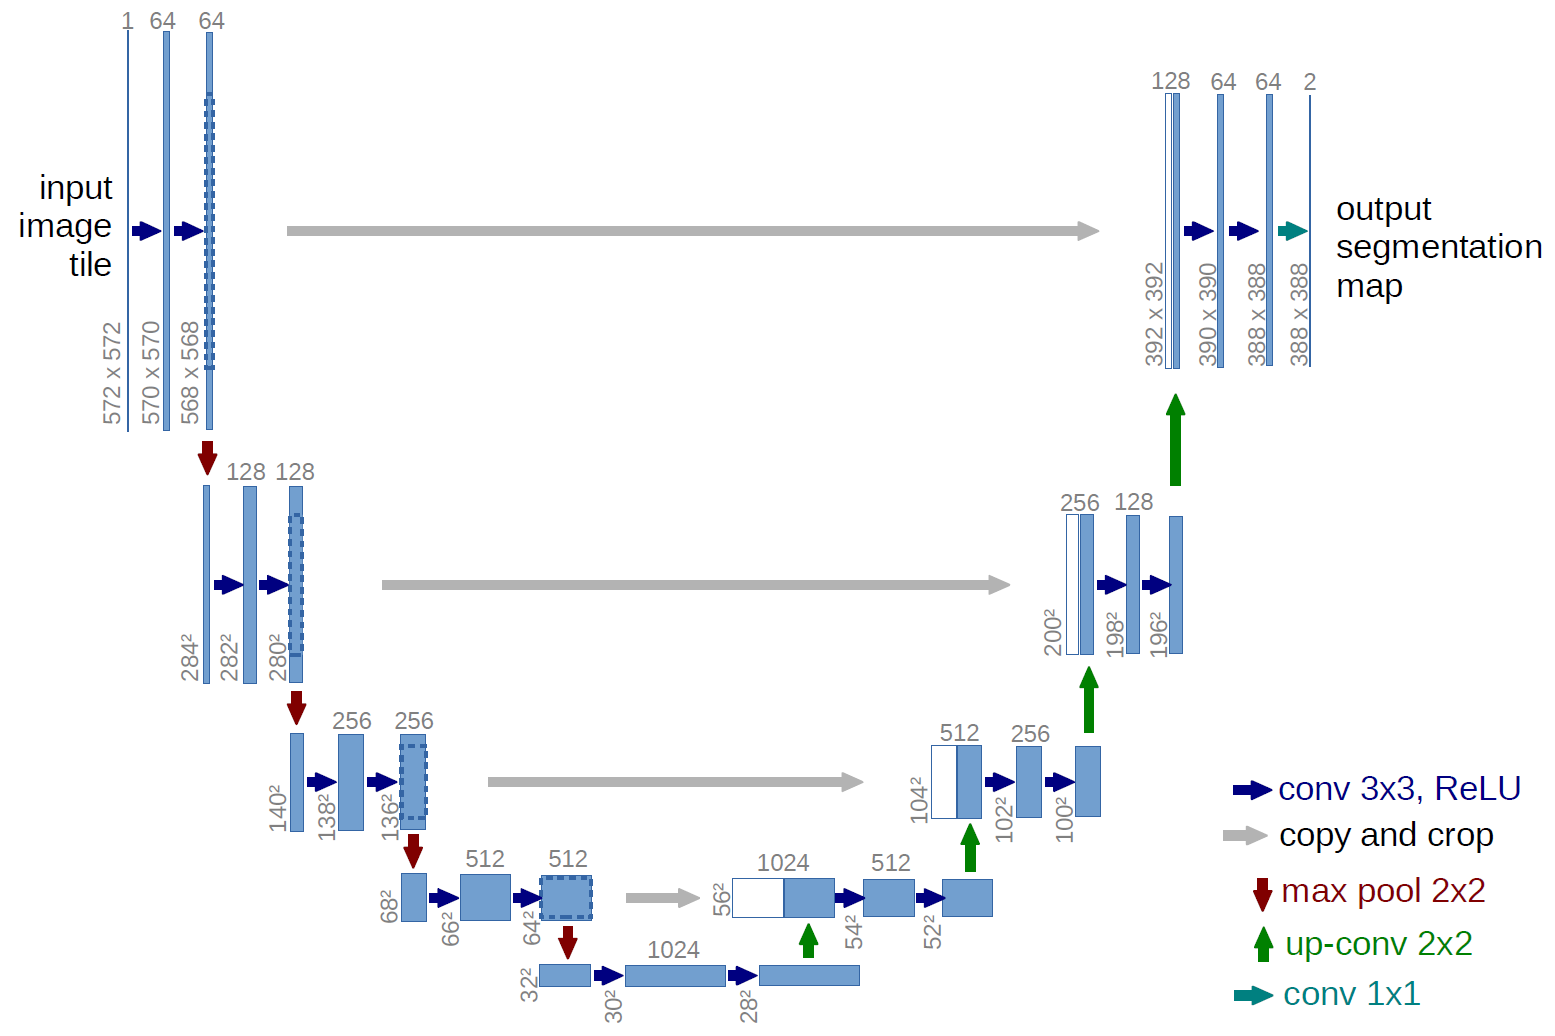

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // 2)
        self.up1 = Up(1024, 512 // 2)
        self.up2 = Up(512, 256 // 2)
        self.up3 = Up(256, 128 // 2)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits